## Basic Settings

In [1]:
import os
import math
import yaml
import boto3
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple, Dict, Union
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from sssd.core.model_specs import setup_model, MASK_FN
from sssd.core.layers.s4.s4_layer import S4Layer
from sssd.core.utils import calc_diffusion_step_embedding
from sssd.data.utils import get_dataloader
from sssd.data.generator import ArDataGenerator
from sssd.data.dataloader import ArDataLoader
from sssd.utils.utils import (
    calc_diffusion_hyperparams,
    sampling,
    std_normal,
    find_repo_root,
    load_yaml_file
)
from sssd.training.utils import training_loss
from sssd.core.imputers.SSSDS4Imputer import SSSDS4Imputer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 4

## Hyperparameters

In [2]:
std = 1
intercept = 0

num_series = 1024
coefficients = [0.8]
season = None
series_length = 128
season = 12
batch_size = 128

training_rate = 0.8
epochs = 1
inference_sample_size = 2
seeds = list(range(num_series))

## Data Generation

In [3]:
data_loader = ArDataLoader(
    coefficients,
    num_series,
    series_length,
    std,
    intercept,
    season,
    batch_size,
    device,
    num_workers,
    training_rate,
    seeds,
)

train_loader = data_loader.train_dataloader
test_loader = data_loader.test_dataloader

## Model Configuration

In [4]:
current_dir = os.getcwd()
repo_root = find_repo_root(current_dir)

configs_dir = os.path.join(repo_root, "configs")
model_config_path = os.path.join(configs_dir, "model.yaml")
training_config_path = os.path.join(configs_dir, "training.yaml")
inference_config_path = os.path.join(configs_dir, "inference.yaml")

# Load the configuration files
model_config = load_yaml_file(model_config_path)
training_config = load_yaml_file(training_config_path)
inference_config = load_yaml_file(inference_config_path)

In [5]:
def update_mask(batch: torch.Tensor) -> torch.Tensor:
    """Update mask based on the given batch."""
    transposed_mask = MASK_FN["forecast"](batch[0], 24)
    return (
        transposed_mask.permute(1, 0)
        .repeat(batch.size()[0], 1, 1)
        .to(device, dtype=torch.float32)
    )

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SSSDS4Imputer(**model_config.get("wavenet"), device=device)
net = net.to(device)
net = nn.DataParallel(net)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

## Model Training

In [7]:
losses = []
diffusion_hyperparams = calc_diffusion_hyperparams(**model_config["diffusion"], device=device)
epoch_pbar = tqdm(range(epochs), desc="Training Epochs")

for epoch in epoch_pbar:
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        mask = update_mask(batch)
        loss_mask = ~mask.bool()

        batch = batch.permute(0, 2, 1)
        assert batch.size() == mask.size() == loss_mask.size()

        optimizer.zero_grad()
        loss = training_loss(
            model=net,
            loss_function=nn.MSELoss(),
            training_data=(batch, batch, mask, loss_mask),
            diffusion_parameters=diffusion_hyperparams,
            generate_only_missing=training_config.get("only_generate_missing"),
            device=device,
        )
        loss.backward()
        optimizer.step()

        epoch_loss += loss.cpu().detach().numpy() / len(train_loader)

    losses.append(epoch_loss)

    epoch_pbar.set_postfix(loss=f'{epoch_loss:.4f}')


print(f"Finished training for {len(losses)} epochs.")

Training Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it, loss=0.9971]

Finished training for 1 epochs.


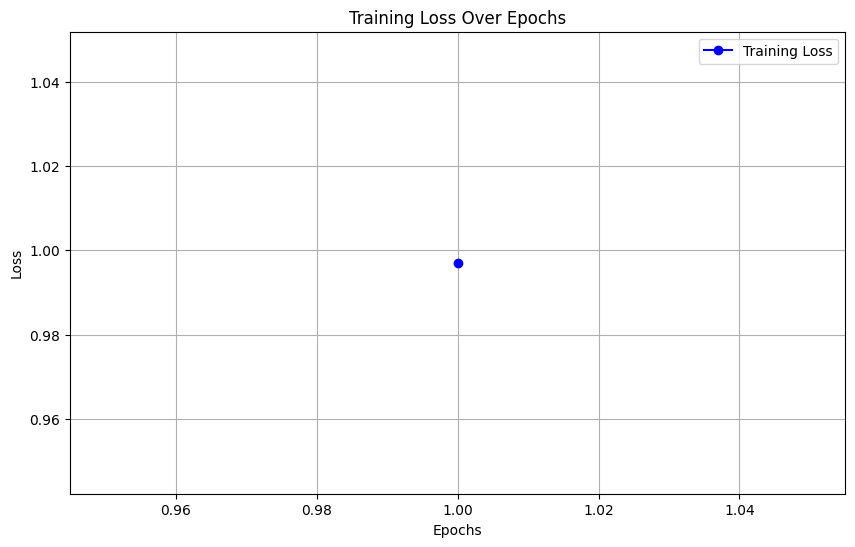

In [8]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b', label='Training Loss')

# Adding title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

## Inference

In [63]:
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming necessary imports and model setup have been done
# net, device, update_mask, sampling, test_loader, diffusion_hyperparams should be defined

# Number of inferences to generate for each batch
inference_sample_size = 2  # Example value, adjust as needed

# List to store all generated results
results = []

# Set the network to evaluation mode
net.eval()

# Iterate over each batch from the test_loader
for batch in tqdm(test_loader, desc="Processing Batches"):
    batch = batch.to(device)
    mask = update_mask(batch)
    
    # Ensure consistency in tensor operations
    assert batch.is_cuda and mask.is_cuda, "Tensors are not on the same device"
    assert batch.dtype == mask.dtype, "Tensors do not have the same dtype"
    
    batch = batch.permute(0, 2, 1)
    
    # Generate multiple samples for each batch
    generated_samples = sampling(
        net=net,
        size=batch.shape,
        diffusion_hyperparams=diffusion_hyperparams,
        cond=batch,
        mask=mask,
        sample_size=inference_sample_size,
        device=device,
    )


    results.append(generated_samples)

Processing Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:03<00:00, 31.92s/it]


In [88]:
mean_prediction = np.vstack([np.mean(result, axis=0) for result in results]).squeeze()
std_prediction =np.vstack([np.std(result, axis=0) for result in results]).squeeze()
mean_mean_prediction = np.mean(mean_prediction, axis=0)
mean_std_prediction = np.mean(std_prediction, axis=0)

median_prediction = np.vstack([np.median(result, axis=0) for result in results]).squeeze()

test_data = torch.stack(list(test_loader.dataset)).squeeze()
mean_true_values = np.mean(test_data.numpy(), axis=0)
std_true_values = np.std(test_data.numpy(), axis=0)

mse_mean_prediction = mean_squared_error(test_data[:,-24:], mean_prediction[:,-24:])
mse_median_prediction = mean_squared_error(test_data[:,-24:], median_prediction[:,-24:])
mape_mean_prediction = mean_absolute_percentage_error(test_data[:,-24:], mean_prediction[:,-24:])
mape_median_prediction = mean_absolute_percentage_error(test_data[:,-24:], median_prediction[:,-24:])

In [77]:
summary_results = {
    'Mean Squared Error': [mse_mean_prediction, mse_median_prediction],
    'Mean Absolute Percentage Error': [mape_mean_prediction, mape_median_prediction]
}

df_results = pd.DataFrame(summary_results, index=['Mean Prediction', 'Median Prediction'])

# Display the table
print(df_results)

                   Mean Squared Error  Mean Absolute Percentage Error
Mean Prediction             17.032423                       14.958263
Median Prediction           17.032423                       14.958263


## Evaluation

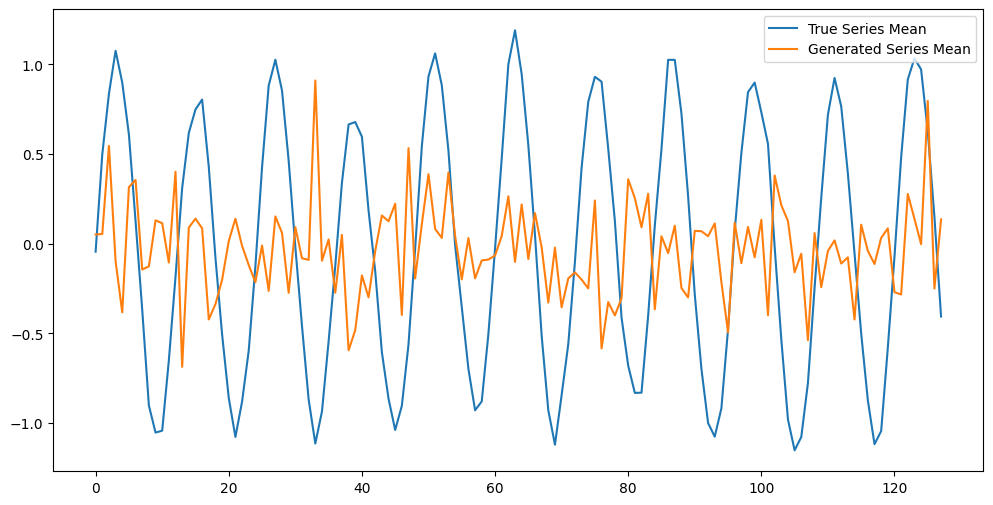

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(series_length), mean_true_values, label='True Series Mean')
plt.plot(np.arange(series_length), mean_mean_prediction, label='Generated Series Mean')
plt.legend()
plt.show()

In [87]:
mean_true_values.shape

(128,)

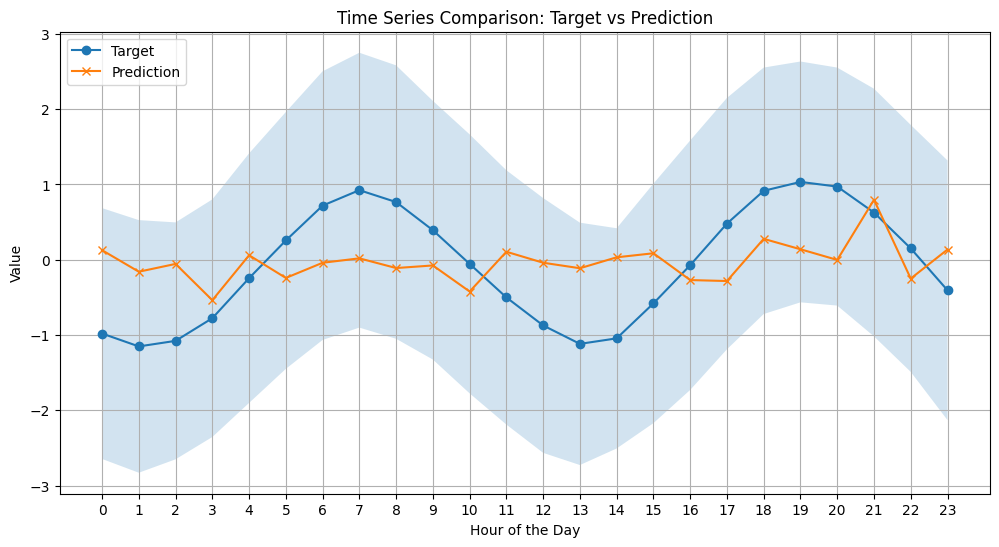

In [94]:
plt.figure(figsize=(12, 6))
hours = range(24)

# Plot true mean with standard deviation band
plt.plot(hours, mean_true_values[-24:], label='Target', marker='o')
plt.fill_between(hours, mean_true_values[-24:] - std_true_values[-24:], 
                 mean_true_values[-24:] + std_true_values[-24:], alpha=0.2)

# Plot prediction mean with standard deviation band
plt.plot(hours, mean_mean_prediction[-24:], label='Prediction', marker='x')
plt.fill_between(hours, mean_mean_prediction[-24:] - mean_std_prediction[-24:], 
                 mean_mean_prediction[-24:] + mean_std_prediction[-24:], alpha=0.2)

plt.xlabel('Hour of the Day')
plt.ylabel('Value')
plt.title('Time Series Comparison: Target vs Prediction')
plt.legend()
plt.grid(True)
plt.xticks(hours)

plt.show()